# Домашнее задание № 9

# Задание 1 (10 баллов)

Визуализируйте attention для одного любого текста после нескольких последовательных эпох обучения, чтобы проанализировать как модель учится понимать текст.
Для этого вам понадобится так изменить код модели из семинара, чтобы Block класс возвращал attention активации (последнее значение wei), а также все остальные классы, которые вызывают Block, чтобы они ожидали, что модель вернет не только out но и wei. В самом верхнеуровневом классе BigramLanguageModel вы можете добавить атрибут last_attentions и в forward перезаписывать его значения последним значением attention (но можно придумать и другой способ). После каждой эпохи вызовите модель на одном примере из датасета и сохраните last_attentions во внешнюю переменную, чтобы потом отдельно заняться визуализацией. Визуализируйте attentions как heatmap'ы (например в searborn). У вас будет attention матрица для каждого слоя и для каждого head в модели. Для каждой нужно будет сделать свой хитмап.
Должно получиться что-то похожее на (только несколько для каждой эпохи)
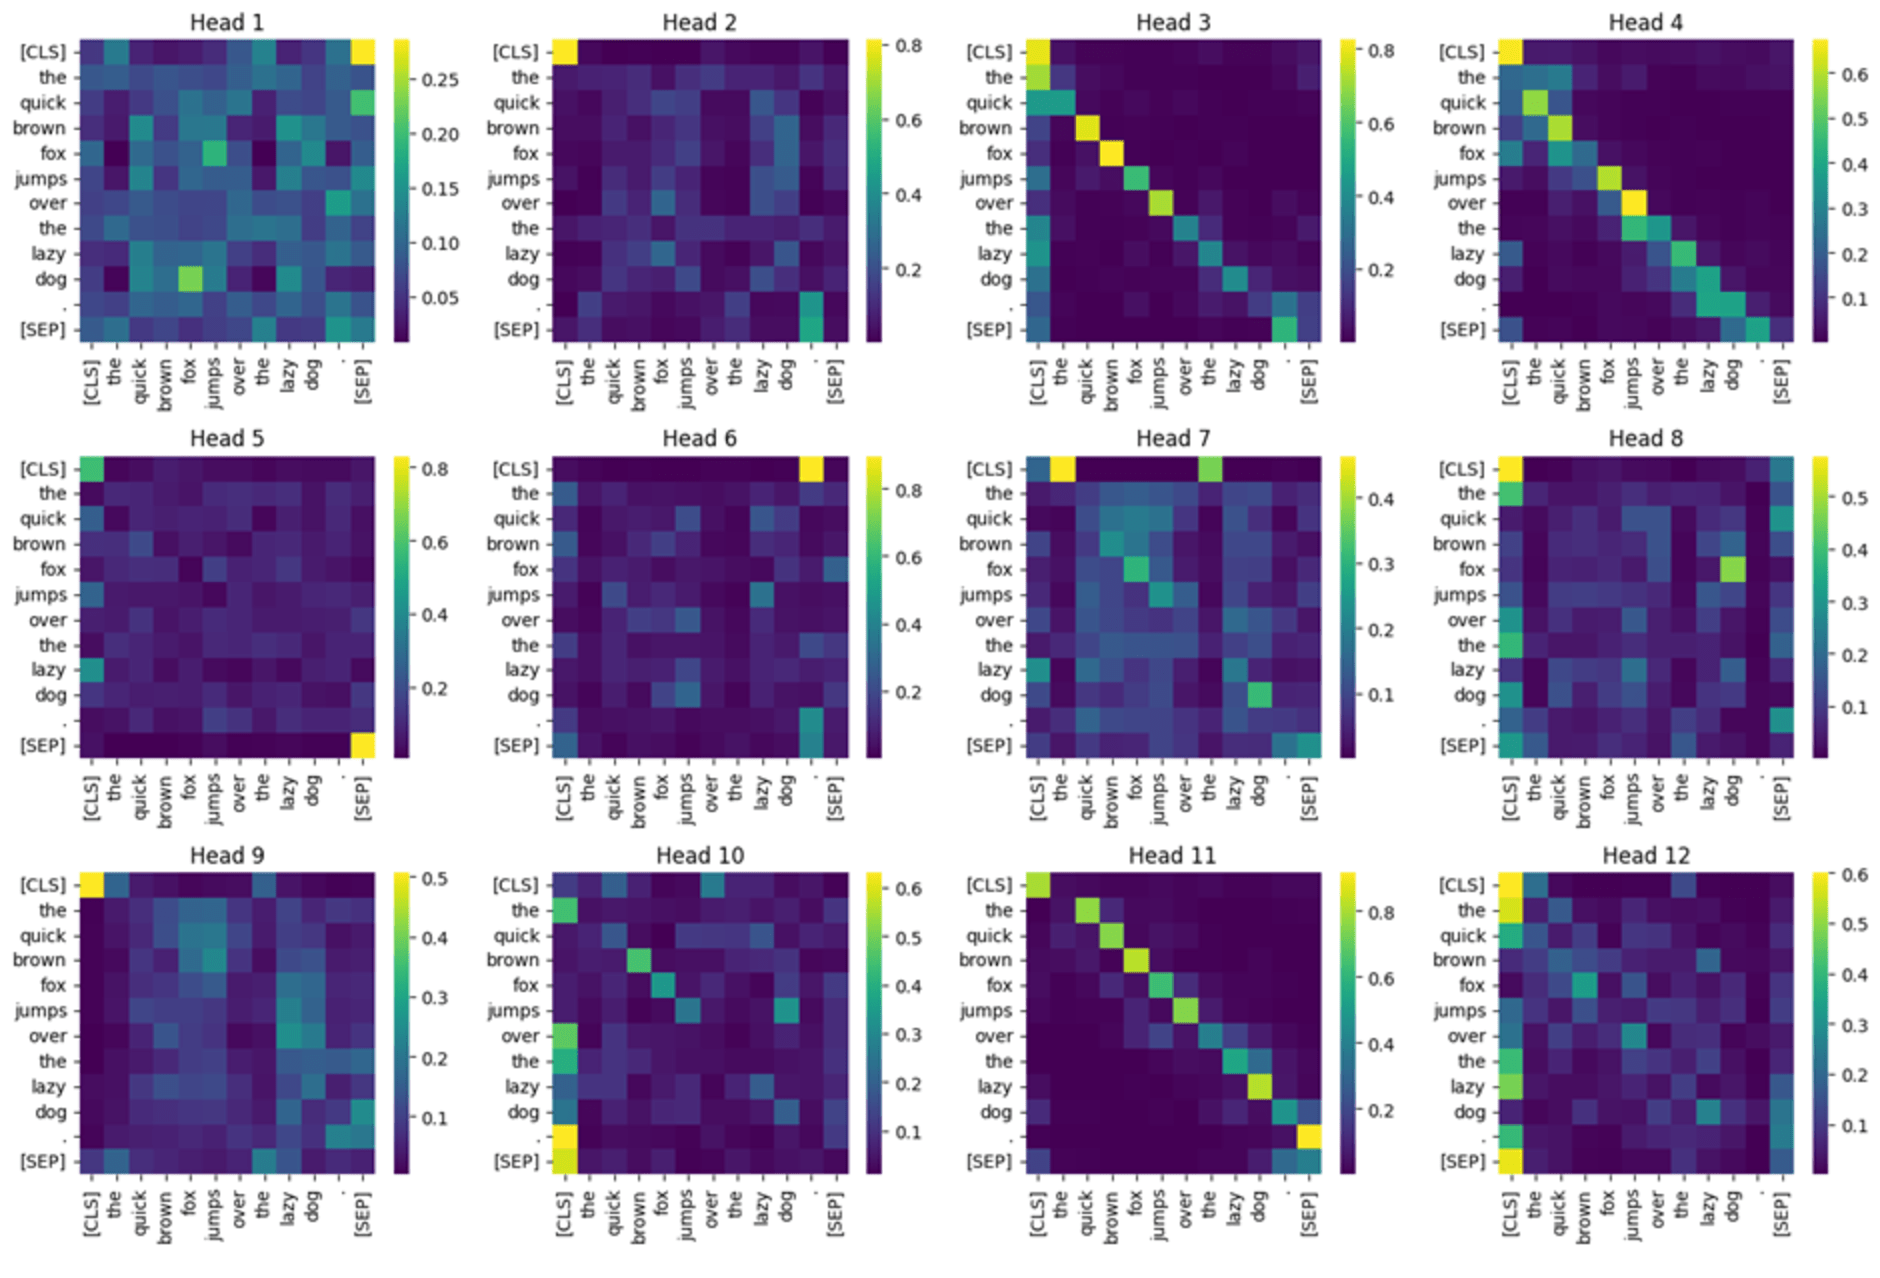![](https://www.kdnuggets.com/wp-content/uploads/How_to_Visualize_Model_Internals_and_Attention_in_Hugging_Face_Transformers_3.png)

# Импорт

In [ ]:
!pip install rusenttokenize

In [ ]:
from rusenttokenize import ru_sent_tokenize
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers import decoders
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

 # Данные

In [ ]:
data = pd.read_csv('https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/data/lenta_40k.csv.zip')
data.head()

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия


# Препроцессинг

In [ ]:
sentences = []
for text in data.text.values:
    sentences.extend(ru_sent_tokenize(text))

# cохраним в отдельный файл чтобы больше не тратить время на токенизацию,
# также файл понадобится дальше для обучения токенизатора
f = open('corpus.txt', 'w')
for sent in sentences:
    f.write(sent + '\n')
f.close()


# код поднимает много ворнингов при токенизации, удалил этот вывод

In [ ]:
sentences = open('corpus.txt').read().splitlines()

In [ ]:
tokenizer = Tokenizer(BPE())
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]"], end_of_word_suffix="</w>")

# токенайзер обучается на файле а не на питоновских списках
tokenizer.train(files=["corpus.txt"], trainer=trainer)

# сохраним токенизатор
tokenizer.save('tokenizer')

# при перезапуске можно просто перезагрузить готовый токенизатор
# также он понадобится если мы решим сохранить модель
# tokenizer = Tokenizer.from_file("tokenizer")

tokenizer.decoder = decoders.BPEDecoder()
vocab_size = tokenizer.get_vocab_size()
print(vocab_size)

30000


In [ ]:
# Посмотрим что получается в результате токенизации
tokenizer.encode('Какой-то напечатанный текст').ids

[867, 995, 535, 720, 686, 3777, 1469, 808, 9357]

# Датасет

In [ ]:
# Напишем еще функцию которая будет подставлять BOS и EOS токены
def encode(text, tokenizer):
    return [tokenizer.token_to_id('[BOS]')] + tokenizer.encode(text).ids + [tokenizer.token_to_id('[EOS]')]

In [ ]:
# Индекс паддинг токена пригодится позже для маскинга
PAD_IDX = tokenizer.token_to_id('[PAD]')
# Зафиксируем здесь макс. размерность
MAX_LEN = 64

In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, sentences, tokenizer, max_len=32):
        # каждое предложение преобразуется в последовательность индексов
        # а списки преобразуются в тензоры
        self.encoded_texts = [torch.LongTensor(encode(sent, tokenizer)[-max_len:]) for sent in sentences]
        # чтобы составить один общий обучающий тензор нужно сравнять длины последовательностей отдельных текстов
        # в торче не такая удобная функция паддинга, поэтому транкация (отрезание лишнего) происходит уже выше
        self.X = torch.nn.utils.rnn.pad_sequence(self.encoded_texts, padding_value=PAD_IDX, batch_first=True)
        self.length = len(self.encoded_texts)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        # обучающий пример для GPT составляется из одного текста
        # x - это все токены кроме последнего
        # y - это все токены кроме первого
        # другими словами, y это x со сдвигом вправо
        # каждый отдельный элемент в y - следующий токен для соответствующего элемента в x
        # tokens = [1,2,3,4,5,0]
        # x = [1,2,3,4,0]
        # y = [2,3,4,5,0]

        # 1 -> 2
        # 1,2 -> 3
        # 1,2,3 -> 4
        # 1,2,3,4 -> 5
        # teacher forcing

        x = self.X[index][:-1]
        y = self.X[index][1:]

        # чтобы не учитывать паддинг нам нужно создать маску
        mask = x!=PAD_IDX

        return x, y, mask

In [ ]:
# Разделим данные на обучающие и валидационные (90% и 10%б соотв-но)
n = int(0.9*len(sentences))
sentences_train = sentences[:n]
sentences_val = sentences[n:]

training_set = Dataset(sentences_train, tokenizer, MAX_LEN)
val_set = Dataset(sentences_val, tokenizer, MAX_LEN)

training_generator = torch.utils.data.DataLoader(training_set, batch_size=200, shuffle=True)
val_generator = torch.utils.data.DataLoader(training_set, batch_size=200, shuffle=False)

In [ ]:
training_set[0]

(tensor([    1,  1911,  2939, 14713,   399,  5442,   833, 13328, 26169, 15291,
           515, 16131,  1126,  1389,  1102, 20933,  2983,  5198, 12060,   691,
          9143, 10699,  2376,   829,   400, 11044,   535,   893,   535, 13170,
           453,     2,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0]),
 tensor([ 1911,  2939, 14713,   399,  5442,   833, 13328, 26169, 15291,   515,
         16131,  1126,  1389,  1102, 20933,  2983,  5198, 12060,   691,  9143,
         10699,  2376,   829,   400, 11044,   535,   893,   535, 13170,   453,
             2,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     

# Определения

In [ ]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf")) # (B, T, T)
        if mask is not None:
            wei.masked_fill(~mask.unsqueeze(1), float("-inf"))
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out, wei

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        head_outputs = []
        attn_weights = []
        for h in self.heads:
            head_out, wei = h(x, mask)
            head_outputs.append(head_out)
            attn_weights.append(wei)

        out = torch.cat(head_outputs, dim=-1)
        out = self.dropout(self.proj(out))
        return out, attn_weights

class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, inp):
        x, mask, all_attn_outputs = inp
        attn_outputs = self.sa(self.ln1(x), mask)
        x = x + attn_outputs[0]
        x = x + self.ffwd(self.ln2(x))
        # attn_outputs[1] is the weights
        all_attn_outputs.extend(attn_outputs[1])
        return (x, mask, all_attn_outputs)

In [ ]:
# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # добавляем attention
        self.last_attentions = None

    def forward(self, idx, targets=None, mask=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x, mask, self.last_attentions = self.blocks((x, mask, [])) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets, ignore_index=PAD_IDX)

        return logits, loss

    def generate(self, idx, max_new_tokens, stop_token):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            if idx_next == stop_token:
                break
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [ ]:
def train(model, iterator, optimizer, print_every=10):
    epoch_loss = []
    model.train()

    for i, (xs, ys, mask) in enumerate(iterator):
        optimizer.zero_grad()
        logits, loss = model(xs.to(device), ys.to(device), mask.to('cuda'))

        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())

        if not (i+1) % print_every:
            print(f'Loss: {torch.Tensor(epoch_loss).mean(-1)}')

    return torch.Tensor(epoch_loss).mean(-1)

def evaluate(model, iterator):
    epoch_loss = []
    model.eval()
    with torch.no_grad():
        for xs, ys, mask in iterator:
            logits, loss = model(xs.to(device), ys.to(device), mask.to('cuda'))
            epoch_loss.append(loss.item())

    return torch.Tensor(epoch_loss).mean(-1)

In [ ]:
def get_attention_values(model, text_embs):
    xs, ys, mask = text_embs
    model.eval() # a kind of switch for some specific layers/parts of the model
    # that behave differently during training and inference (evaluating) time
    with torch.inference_mode():
        logits, loss = model(
            xs.unsqueeze(0).to(device),
            ys.unsqueeze(0).to(device),
            mask.unsqueeze(0).to(device)
        )
    text_len = mask.sum()
    attention_values = []
    for a in model.last_attentions:
        attention_values.append(
            a[:, :text_len, :text_len].squeeze().detach().cpu().numpy()
            )
    return attention_values

# Обучение

In [ ]:
# hyperparameters
block_size = MAX_LEN # what is the maximum context length for predictions?
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 64 # размерность эмбеддингов и векторов внутри трансформера
#ffn_hid_dim = n_embd * 4
n_head = 4
n_layer = 3 # поставил три слоя, чтобы воспроизвести картинку из задания
dropout = 0.0

In [ ]:
model = BigramLanguageModel()
m = model.to(device)

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

4.0236 M parameters


In [ ]:
# Код обучения просто передает в модель батчи из датасета
# При обучении после каждой эпохи генерируется текст чтобы видеть прогресс
# Плюс записываем attention для конкретной фразы из датасета

n_epochs = 3 # т.к. нет цели обучить хорошо, сэкономим вычисления
train_losses = []
eval_losses = []

phrase_id = 4
attention_list = []

for i in tqdm(range(n_epochs)):
    print()
    print(i)
    train_losses.append(train(model, training_generator, optimizer, 100))

    eval_loss = evaluate(model, val_generator)
    print('Eval ---', eval_loss.item())
    eval_losses.append(eval_loss)

    # какие примеры подаются: для наглядности
    # правда, видно, что там не идеальные примеры
    for _ in range(3):
        pred = model.generate(torch.LongTensor(
            [[tokenizer.token_to_id('[BOS]')]]).to('cuda'), 200, tokenizer.token_to_id('[EOS]'))
        print(tokenizer.decoder.decode([tokenizer.id_to_token(i) \
                                        for i in pred.detach().cpu().numpy()[0]][1:-1]))

    # attention
    attention_list.append(get_attention_values(model, val_set[phrase_id]))

  0%|          | 0/3 [00:00<?, ?it/s]


0
Loss: 8.582703590393066
Loss: 8.171616554260254
Loss: 7.974311351776123
Loss: 7.832305431365967
Loss: 7.720060348510742
Loss: 7.619814395904541
Loss: 7.532104015350342
Loss: 7.449582099914551
Loss: 7.371172904968262
Loss: 7.297914981842041
Loss: 7.227808475494385
Loss: 7.162435054779053
Loss: 7.1010260581970215
Loss: 7.041991710662842
Loss: 6.987081527709961
Loss: 6.934783935546875
Loss: 6.88503885269165
Loss: 6.837906360626221
Loss: 6.793408393859863
Loss: 6.751267433166504
Loss: 6.711080551147461
Loss: 6.67259407043457
Eval --- 5.786837577819824


 33%|███▎      | 1/3 [06:34<13:09, 394.70s/it]

Овесы , ученые назвал на жизнь в мобильных компании конструкчного управления личных P сын ( расписающийся Evenpriia icmings ), заявил агентству Олимпийские 2005 Reuters
« 6 , 17 марта , что на работу изобравлияет еще на воду
В настоящее время своего тайфув иностранного Республики Шаме 16 километров

1
Loss: 5.77894401550293
Loss: 5.763824939727783
Loss: 5.746761798858643
Loss: 5.733749866485596
Loss: 5.718869686126709
Loss: 5.703798294067383
Loss: 5.692254543304443
Loss: 5.679067611694336
Loss: 5.666703224182129
Loss: 5.654606342315674
Loss: 5.642873287200928
Loss: 5.630427360534668
Loss: 5.619706153869629
Loss: 5.608875751495361
Loss: 5.598219871520996
Loss: 5.588139533996582
Loss: 5.578427314758301
Loss: 5.568997383117676
Loss: 5.559549808502197
Loss: 5.550426959991455
Loss: 5.541349411010742
Loss: 5.532400608062744
Eval --- 5.272023677825928
Абибитмгния также - мир - южноКорнул


 67%|██████▋   | 2/3 [13:09<06:34, 394.82s/it]

Как тушении данных пункта об обыске тренра ему работать над Европейской корпорации размером примерно 16 , 2 миллиарда кубометров газа , при всей видимости и проведении поединок планировали
Их эти работы в государственных отношениях отмечают , что не склонствулось второй контракт за знать Россию

2
Loss: 5.264706611633301
Loss: 5.264567852020264
Loss: 5.262567520141602
Loss: 5.261080265045166
Loss: 5.257462978363037
Loss: 5.25275182723999
Loss: 5.249431610107422
Loss: 5.245566368103027
Loss: 5.242424011230469
Loss: 5.238229274749756
Loss: 5.234437942504883
Loss: 5.230836391448975
Loss: 5.227437496185303
Loss: 5.224226951599121
Loss: 5.2209553718566895
Loss: 5.217082500457764
Loss: 5.213061809539795
Loss: 5.209772109985352
Loss: 5.206509113311768
Loss: 5.202845573425293
Loss: 5.199146747589111
Loss: 5.195549488067627
Eval --- 5.046024799346924
12 декабря компания Capcom полностью будет продавать способ платежных услуг США и подержаться башкий корабль


100%|██████████| 3/3 [19:45<00:00, 395.04s/it]

Взамен роста налогов отказывался с ним
Москва отдал забояться полеты в Германии и Сенат чеченского клуба к достижению коалиции и Минэкономразвития


# Визуализация

In [ ]:
tokens = []
xs, ys, mask = val_set[phrase_id]
for i, id in enumerate(xs.tolist()):
    if mask[i]:
        tokens.append(tokenizer.id_to_token(id).strip('</w>'))
print(*tokens)

[BOS] Уже велась подготовка к отправ ке первой партии нелега лов , состоя щей из трех человек . [EOS]


In [ ]:
def get_plots(attention_values, tokens):
    fig, axes = plt.subplots(
        n_layer, n_head,
        figsize=(16, 16)
    )
    ct = 1
    for i in range(n_layer):
        for j in range(n_head):
            ax = axes[i, j]
            sns.heatmap(
                attention_values[i * n_head + j],
                ax=ax, cmap="viridis",
                xticklabels=tokens, yticklabels=tokens
            )
            ax.set_title(f"#{ct} Layer {i + 1}, Head {j + 1}")
            ct += 1
    plt.tight_layout()
    plt.show()

0


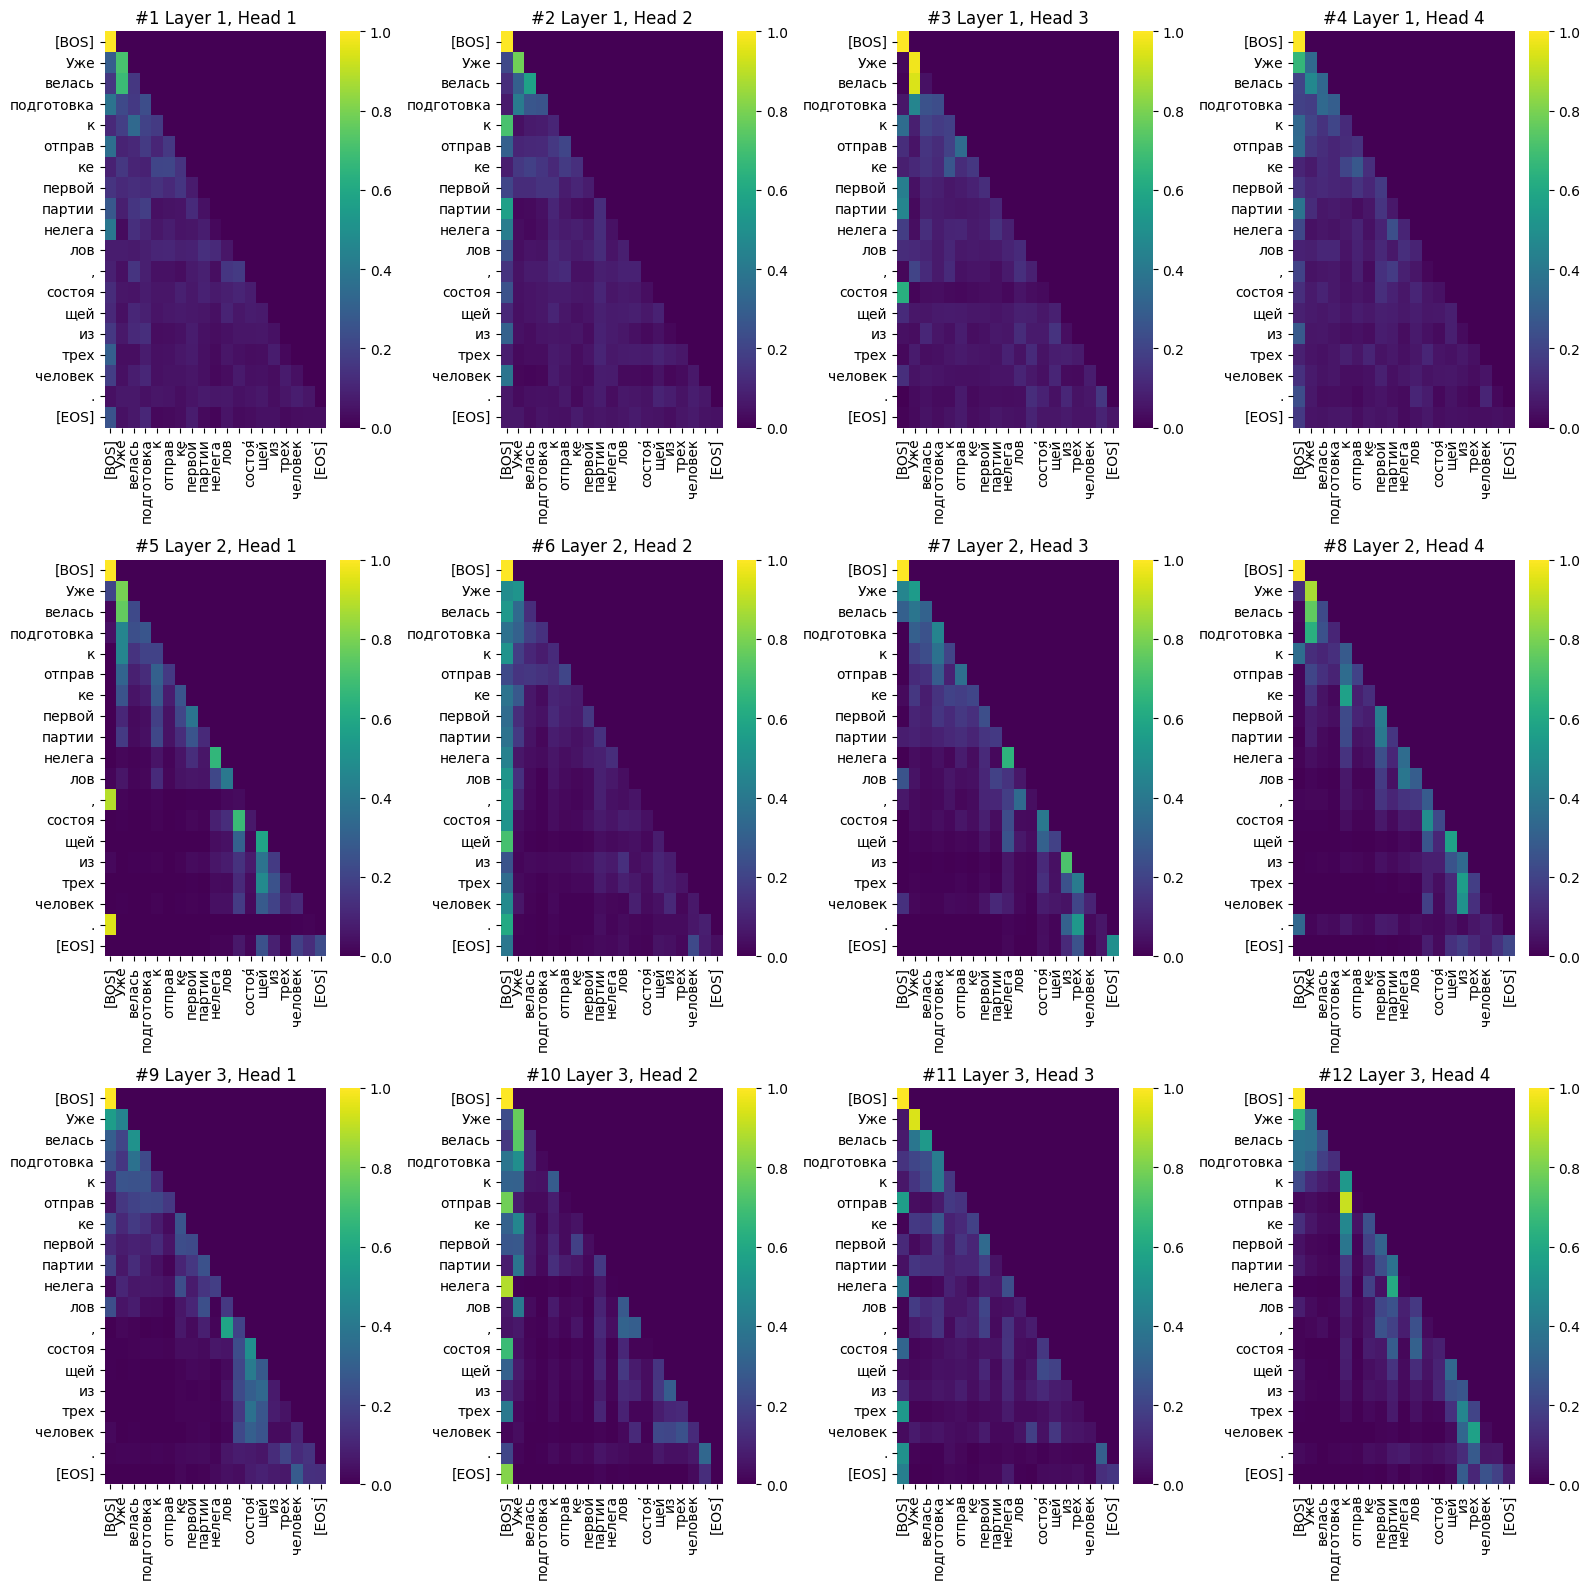

1


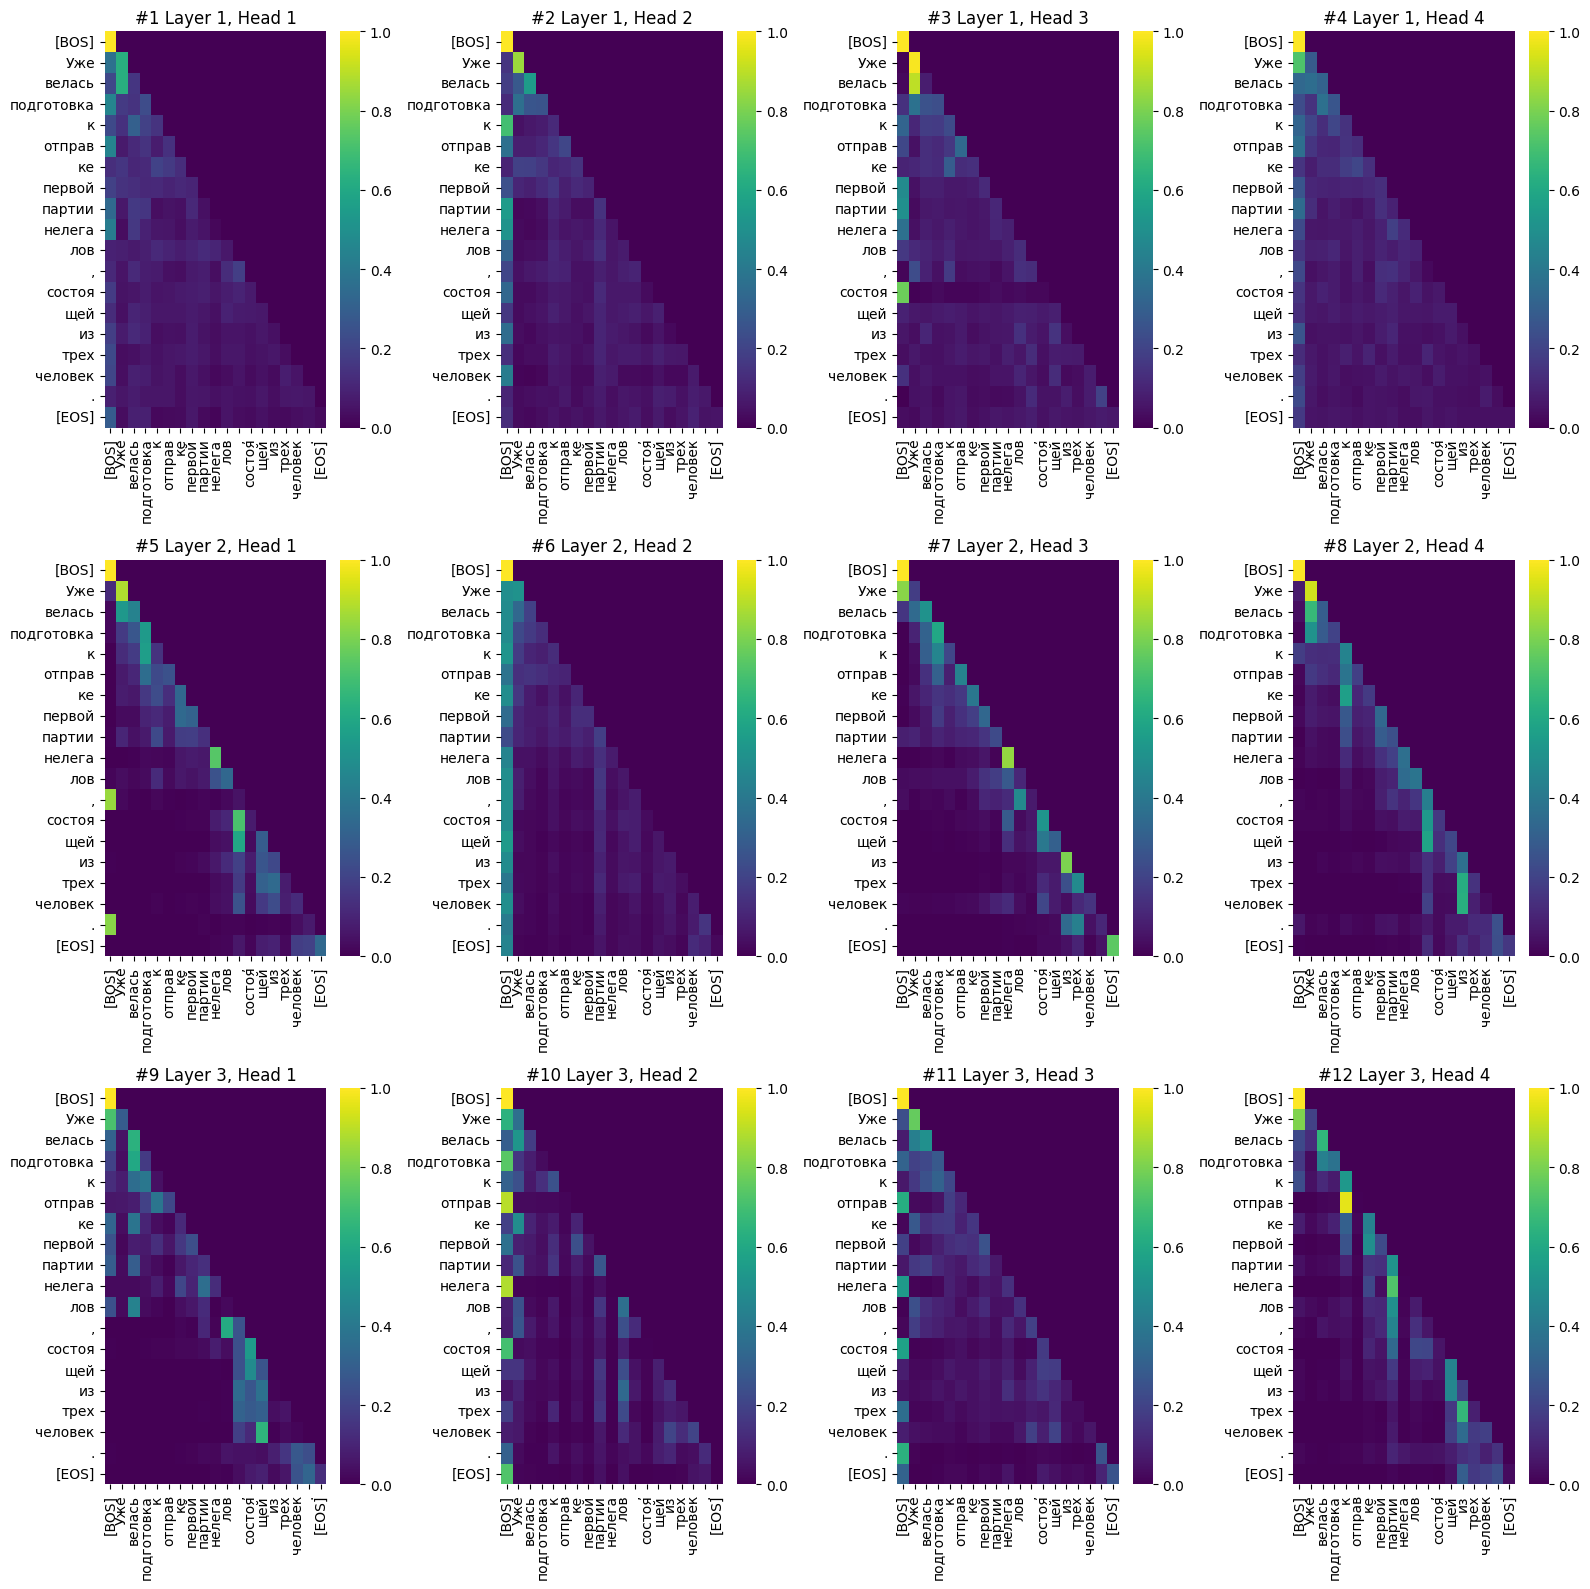

2


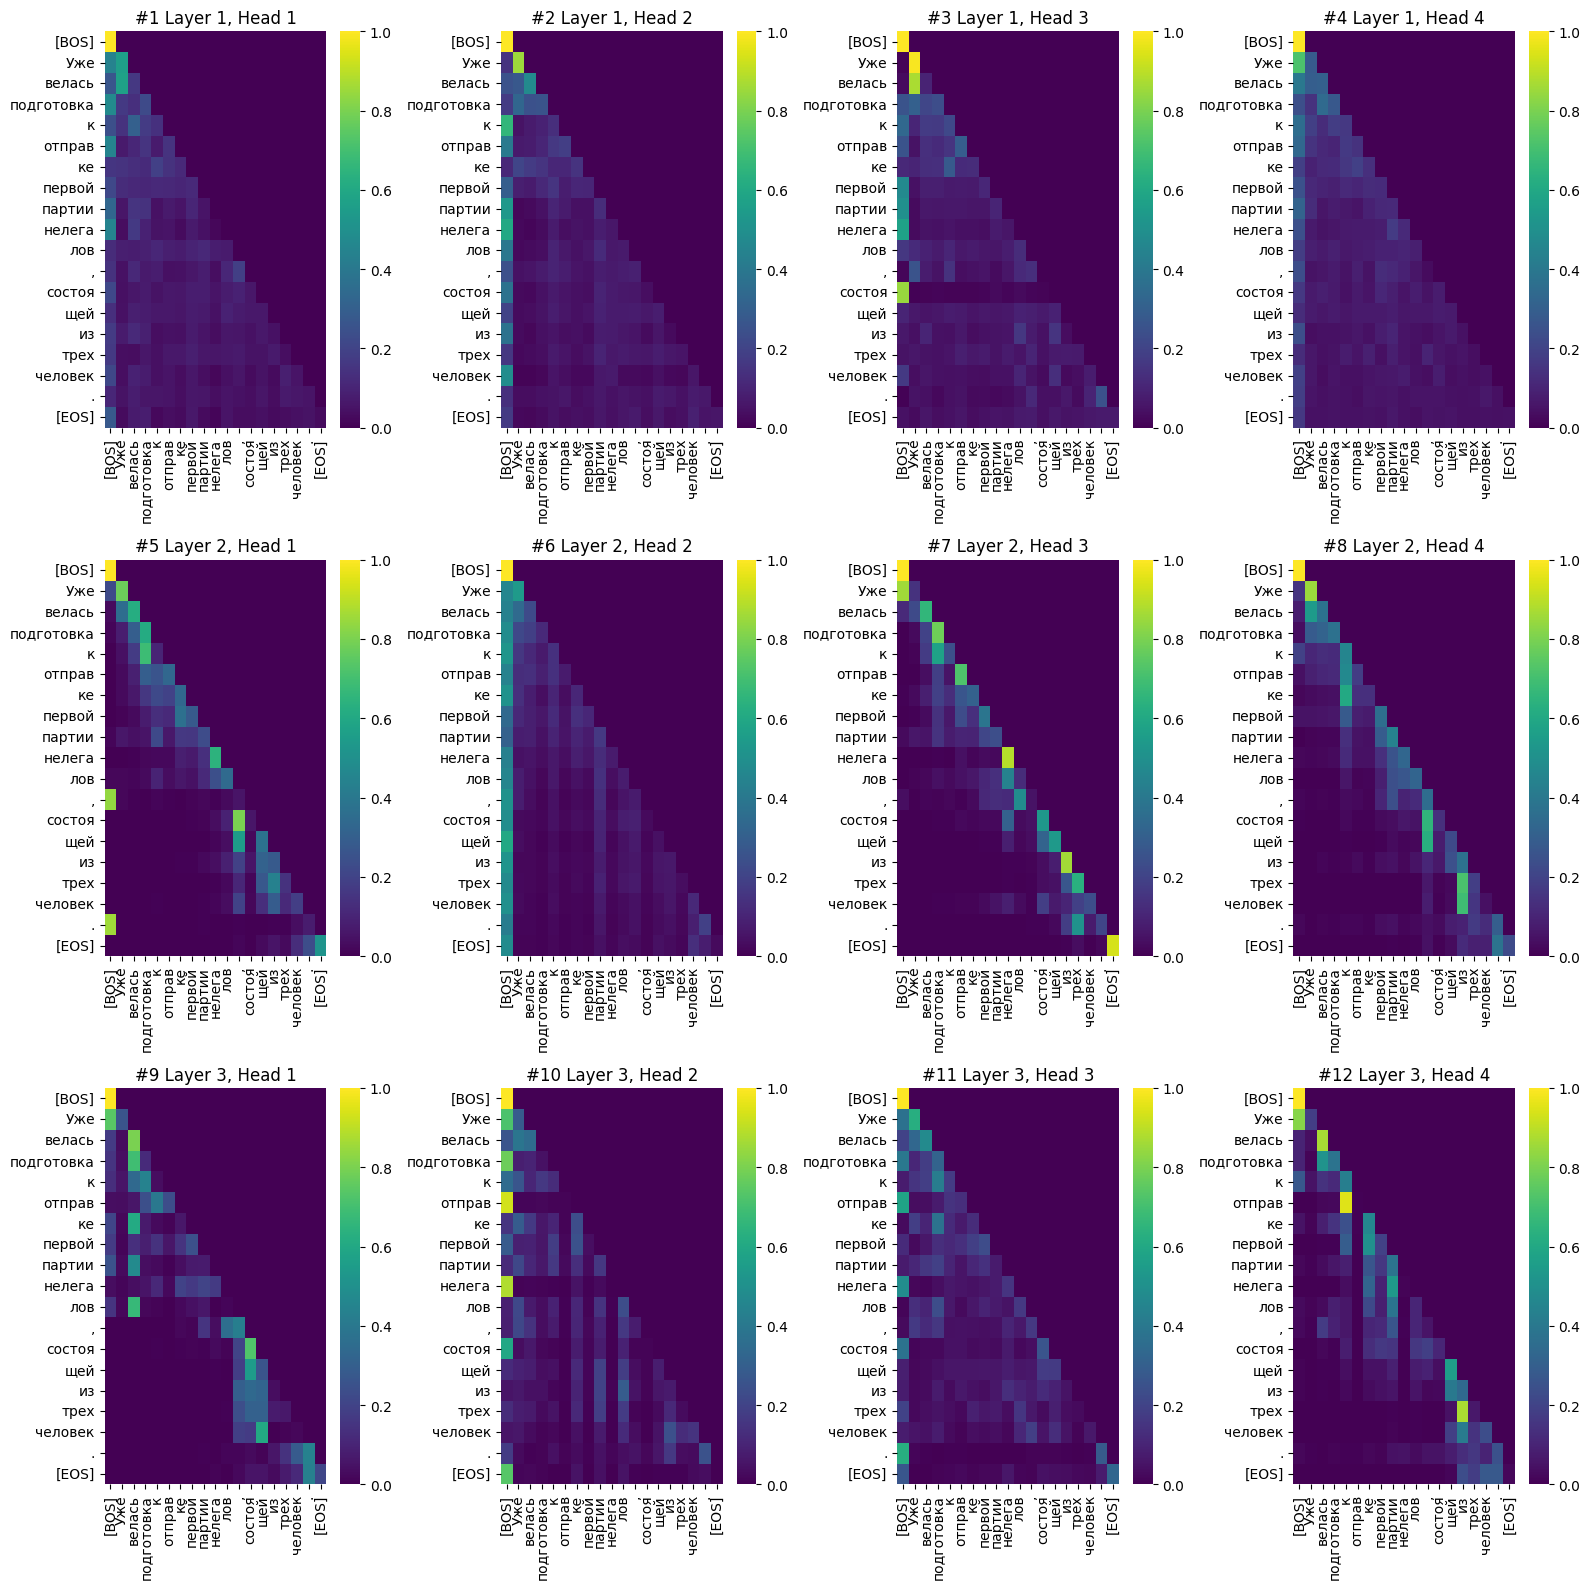

In [ ]:
for epoch, attns in enumerate(attention_list):
    print(f"{epoch}")
    get_plots(attns, tokens)

    # только эпоха очень мелко напечатана, не сразу видно